<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap13_2_word_embeddings_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-datasets
!pip install -U keras
!pip install -U tensorflow
!pip install -U gensim

In [2]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Embedding,Activation,SimpleRNN,BatchNormalization,RNN,Flatten,Input,LSTM,Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import gensim
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Activation,Embedding,SimpleRNN,Dropout
from keras.utils.np_utils import to_categorical

In [5]:
ds_train = tfds.load('snli', split='train[50%:]', shuffle_files=True)
ds_valid = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)

In [6]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [7]:
def preprocessDataFrame(df):

    dic = {}
    dic['premise_hypothesis'] = []
    dic['label'] = []

    hypothesis = [x.decode('utf-8') for x in df['hypothesis'].values]
    premise = [x.decode('utf-8') for x in df['premise'].values]

    for idx,sentence in enumerate(premise):
        dic['premise_hypothesis'].append(premise[idx]+" "+hypothesis[idx])
        dic['label'].append(df['label'][idx])
        
    return pd.DataFrame.from_dict(dic)

In [8]:
df_train = preprocessDataFrame(df_train)
df_valid = preprocessDataFrame(df_valid)
df_test = preprocessDataFrame(df_test)

In [9]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [10]:
train_tweets = df_train['premise_hypothesis'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [11]:
trunc_type = 'post'
padding_type = 'post'
max_length = 32
vocab_size = len(vocabulary)

In [12]:
train_tweets = df_train['premise_hypothesis'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['premise_hypothesis'])

word_index = tokenizer.word_index
print(f"{word_index['blue']} is the index of word 'blue'")
print(f"{word_index['launch']} is the index of word 'launch'")

train_sequences = tokenizer.texts_to_sequences(df_train['premise_hypothesis'])
valid_sequences = tokenizer.texts_to_sequences(df_valid['premise_hypothesis'])
test_sequences = tokenizer.texts_to_sequences(df_test['premise_hypothesis'])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

30 is the index of word 'blue'
4478 is the index of word 'launch'


In [13]:
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True,limit=10000)

result = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('royal', 0.493820458650589)]


In [14]:
embedding_dim=300
num_tokens=vocab_size
vocabulary_size=min(len(word_index)+1,num_tokens)
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in word_index.items():
    if i>=num_tokens:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_dim)

del(word_vectors)

In [15]:
num_tokens

45451

In [16]:
from tensorflow import keras
embedding_layer = Embedding(
    vocabulary_size,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [17]:
model = Sequential()

model.add(Input((None,), dtype="int64"))
model.add(embedding_layer)

model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(valid_padded, y_valid))

Epoch 1/5
4299/4299 [==============================] - 607s 140ms/step - loss: 0.9328 - accuracy: 0.5549 - val_loss: 0.9346 - val_accuracy: 0.6025
Epoch 2/5
4299/4299 [==============================] - 590s 137ms/step - loss: 0.8083 - accuracy: 0.6414 - val_loss: 0.8751 - val_accuracy: 0.6382
Epoch 3/5
4299/4299 [==============================] - 590s 137ms/step - loss: 0.7510 - accuracy: 0.6723 - val_loss: 0.8655 - val_accuracy: 0.6440
Epoch 4/5
4299/4299 [==============================] - 595s 138ms/step - loss: 0.7078 - accuracy: 0.6968 - val_loss: 0.8403 - val_accuracy: 0.6621
Epoch 5/5
4299/4299 [==============================] - 595s 138ms/step - loss: 0.6671 - accuracy: 0.7183 - val_loss: 0.8383 - val_accuracy: 0.6679


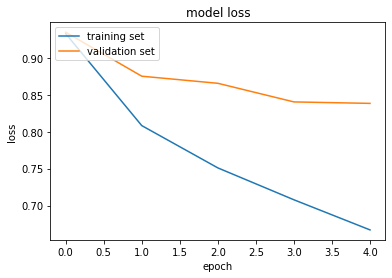

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [19]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred))

313/313 [==============================] - 13s 38ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.68      0.74      0.71      3368
           2       0.67      0.63      0.65      3219
           3       0.68      0.70      0.69      3237

    accuracy                           0.68     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.67      0.68      0.67     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
